# This project implemented by Elham Mahdipour
## I am a Ph.D. Graduate  of computer engineering at Yazd University, Yazd, Iran.
## I am a Faculty Member of Computer Engineering Department at Khavaran Institute of Higher Education, Mashhad, Iran.
### Please feel free and contact to me: elham.mahdipour@gmail.com/ e.mahdipour@profs.khi.ac.ir

# Please run all cells for test the RENA model. This program test RENA tune model for CE-SC species.

# Phase 1 
## Create Dataset and Preprocessing

In [2]:
import networkx as nx
G1=nx.read_weighted_edgelist('large dataset\sc-sc.evals')
G1

In [3]:
G2=nx.read_weighted_edgelist('large dataset\ce-ce.evals')
G2

In [4]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp
print(len(G1))
print(len(G2))

6613
19702


In [5]:
G_target_na=nx.read_weighted_edgelist('large dataset\ce-sc.evals')
G_target_na  

In [6]:
ed1=G1.edges()
ed2=G2.edges()

nd1=G1.nodes()
nd2=G2.nodes()

el1=list(ed1)
el2=list(ed2)

nd1=list(nd1)
nd2=list(nd2)

degG1 = [val for (node, val) in G1.degree()]
degG2 = [val for (node, val) in G2.degree()]

# Feature Extraction

# compute score for create similarity matrix

In [7]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [8]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [9]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [10]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node

In [11]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [12]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [13]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [14]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s,coeff_pr, dd, cd

In [15]:
import numpy as np
m, coeff_pr, dd, cd=compute_score(G1,G2)
sim=m

# Phase 2: Dataset Generation

# create data for deep learning

# change problem to classification 
## [node of G1, node of G2, Coefficient page rank, clustering coefficient difference,  similarity score, alignment=yes(0)/TN or no(1)/TP]

In [16]:
import numpy as np
int_nd1=np.zeros(len(nd1))
int_nd2=np.zeros(len(nd2))

species=['ec','sc','ce','dm','mm','hs']
ch1=0  #please set index for first species of species list, for example index of ec is 0
ch2=1  #please set index for second species of species list, for example index of sc is 1
# If don't set index with considering species may be given an error
for i in range(len(nd1)):
    if (species[ch1] in nd1[i] or species[ch2] in nd1[i]):
        s=nd1[i][2:]
        x=int(s)
        int_nd1[i]=x    
for i in range(len(nd2)):
    if (species[ch1] in nd2[i] or species[ch2] in nd2[i]):
        s=nd2[i][2:]
        x=int(s)
        int_nd2[i]=x    

In [17]:
# en_mat is encoding matrix
en_mat=[]

for i in range(len(nd1)):
    for j in range(len(nd2)):
        if G_target_na.has_edge(nd1[i],nd2[j]):
            align_class='Yes'
        else:
            align_class='No'
        
        sample=[int_nd1[i],int_nd2[j], coeff_pr[i][j], dd[i][j],cd[i][j],sim[i][j],align_class] 
        en_mat.append(sample)
print(len(en_mat))

130289326


In [18]:
yc=[]
noc=[]
for i in range(len(en_mat)):
    if en_mat[i][6]=='Yes': 
        yc.append(en_mat[i])
    else:
        noc.append(en_mat[i])
print(len(yc), len(noc))

36069 130253257


In [19]:
data=yc+noc[0:30000000] 
len(data)
X=[]
y=[]
for i in range(len(data)):
    X.append(data[i][0:6])
    y.append(data[i][6])
    
len(X),len(y)

(30036069, 30036069)

In [19]:
data=yc+noc[0:30000000] 
len(data)
X=[data[i][0:7] for i in range(len(data))]
y=[data[i][7] for i in range(len(data))]
len(X),len(y)

(30036069, 30036069)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [23]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

27032462 27032462 3003607 3003607


In [21]:
import pandas as pd
f=pd.DataFrame(en_mat,columns=['node_of_G1','node_of_G2','Coefficient_pagerank','Degree_Difference', 'clustering_coefficient_difference', 'similarity_score', 'alignment_class'])
f.head()

,node_of_G1,node_of_G2,Coefficient_pagerank,Degree_Difference,clustering_coefficient_difference,similarity_score,alignment_class
0,4957.0,1135.0,0.587525,0.857143,0.376590,0.194501,No
1,4957.0,2121.0,0.451251,0.933333,0.261905,0.215827,No
2,4957.0,2223.0,0.514533,0.931818,0.239807,0.214222,No
3,4957.0,7526.0,0.427855,0.930233,0.231134,0.224941,No
4,4957.0,1189.0,0.241747,0.930233,0.217371,0.246305,No


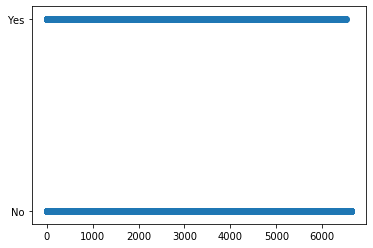

In [33]:
import matplotlib.pyplot as plt
plt.scatter(f['node_of_G1'], f['alignment_class'])
plt.show()

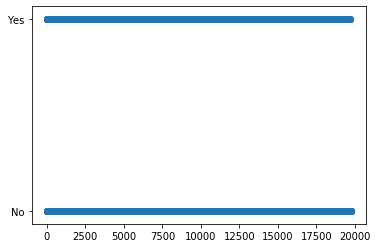

In [34]:
import matplotlib.pyplot as plt
plt.scatter(f['node_of_G2'], f['alignment_class'])
plt.show()

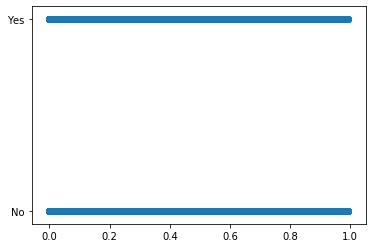

In [32]:
import matplotlib.pyplot as plt
plt.scatter(f['Degree_Difference'], f['alignment_class'])
plt.show()

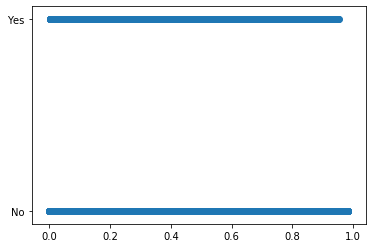

In [31]:
import matplotlib.pyplot as plt
plt.scatter(f['Coefficient_pagerank'], f['alignment_class'])
plt.show()

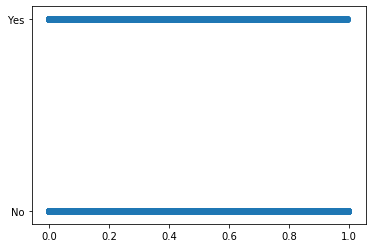

In [28]:
import matplotlib.pyplot as plt
plt.scatter(f['clustering_coefficient_difference'], f['alignment_class'])
plt.show()

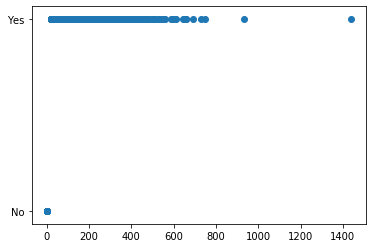

In [22]:
import matplotlib.pyplot as plt
plt.scatter(f['similarity_score'], f['alignment_class'])
plt.show()

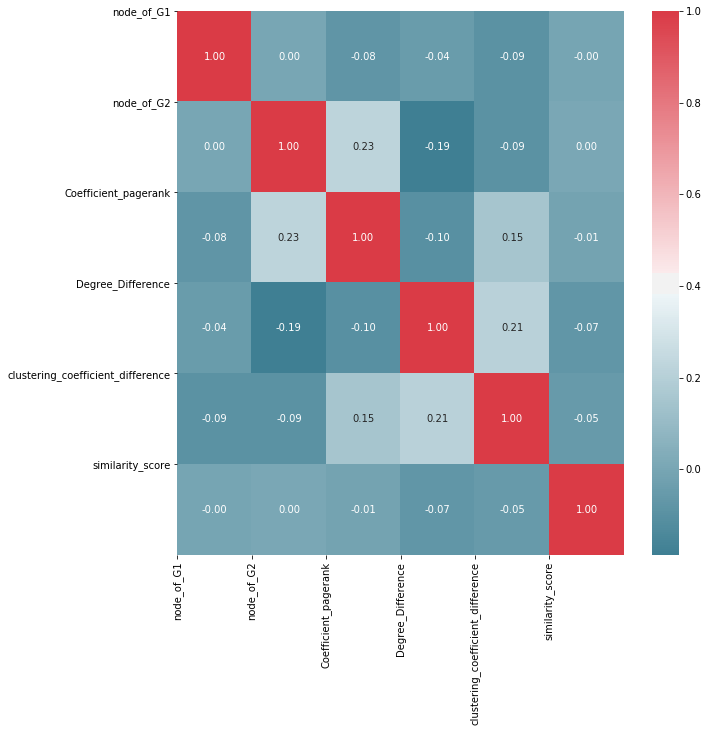

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#f=pd.DataFrame(X_train)
corr = f.corr()
   #Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map, red & blue
colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
plt.show()

In [37]:
import numpy as np
print(max(f.similarity_score),min(f.similarity_score),np.mean(f.similarity_score),np.median(f.similarity_score))

1439.433565120292 0.0046957873694995714 0.29651539410216277 0.26380669119349875


In [40]:
x_tr,y_tr,x_te,y_te=X_train, y_train,X_test,y_test

# test model for real data

In [ ]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# One Hot Encode
y_train = np_utils.to_categorical(encoded_Y)

In [ ]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# One Hot Encode
y_test = np_utils.to_categorical(encoded_Y)

In [ ]:
import numpy as np
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

# Phase 3: RENA network

## Load tune RENA model

In [44]:
from keras.models import load_model
#del model
model_rnn = load_model('large dataset/deep_model_resample_6features_undersampling-rnn_ec-sc.h5')
model_rnn.load_weights('large dataset/deep_model_resample_6features_undersampling-rnn_weights_ec-sc.h5', by_name=True)

In [46]:
results_tr = model_rnn.evaluate(X_train, y_train)
results_tr

27032462/27032462 [==============================] - 1584s 59us/step


[0.0, 1.0, 0.0, 0.0]

In [47]:
%%time
output_tr=model_rnn.predict(X_train)
output_tr

Wall time: 12min 31s


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [48]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train.argmax(axis=1), output_tr.argmax(axis=1)))

[[27000030        0]
 [       0    32432]]


In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_train.argmax(axis=1), output_tr.argmax(axis=1) , average="macro"))
print(recall_score(y_train.argmax(axis=1), output_tr.argmax(axis=1) , average="macro"))
print(f1_score(y_train.argmax(axis=1), output_tr.argmax(axis=1) , average="macro"))

1.0
1.0
1.0


In [50]:
results_te = model_rnn.evaluate(X_test, y_test)
results_te

3003607/3003607 [==============================] - 190s 63us/step


[0.0, 1.0, 0.0, 0.0]

In [51]:
%%time
output_te=model_rnn.predict(X_test)
#print(output_te)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), output_te.argmax(axis=1)))
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))

[[2999970       0]
 [      0    3637]]
1.0
1.0
1.0
Wall time: 1min 30s


# Test RENA before resample

In [52]:
from keras.models import load_model
model_rnn = load_model('large dataset/deep_model_before_resample_6features_rnn_ec-sc.h5')
model_rnn.load_weights('large dataset/deep_model_before_resample_6features_rnn_weights_ec-sc', by_name=True)

In [53]:
results_tr = model_rnn.evaluate(X_train, y_train)
results_tr

27032462/27032462 [==============================] - 1608s 59us/step


[nan, 0.9992299675941467, nan, nan]

In [54]:
%%time
output_tr=model_rnn.predict(X_train)
output_tr

Wall time: 13min 3s


array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

In [55]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train.argmax(axis=1), output_tr.argmax(axis=1)))

[[27000030        0]
 [   32432        0]]


In [56]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_train.argmax(axis=1), output_tr.argmax(axis=1) , average="macro"))
print(recall_score(y_train.argmax(axis=1), output_tr.argmax(axis=1) , average="macro"))
print(f1_score(y_train.argmax(axis=1), output_tr.argmax(axis=1) , average="macro"))

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4994001286305332
0.5
0.4996998842844413


In [57]:
results_te = model_rnn.evaluate(X_test, y_test)
results_te

3003607/3003607 [==============================] - 189s 63us/step


[nan, 0.9987891316413879, nan, nan]

In [58]:
%%time
output_te=model_rnn.predict(X_test)
#print(output_te)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), output_te.argmax(axis=1)))
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), output_te.argmax(axis=1) , average="macro"))

[[2999970       0]
 [   3637       0]]
0.4993945612724967
0.5
0.49969709724719114
Wall time: 1min 29s


# test other classifier without resample

In [59]:
x_tra,y_tra,x_tes,y_tes=X_train,y_train,X_test,y_test

In [60]:
X_train,y_train,X_test,y_test=x_tr,y_tr,x_te,y_te

In [79]:
%%time
# Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 1.00
Accuracy of LDA classifier on test set: 1.00
Wall time: 1min 38s


In [80]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds_tr = lda.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9998236194690665
[[27000030        0]
 [    4768    27664]]
0.9999117193914948
0.9264923532313765
0.9602859942438249
Wall time: 3min 42s


In [81]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds = lda.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9998248772226194
[[2999970       0]
 [    526    3111]]
0.9999123478251596
0.9276876546604345
0.960981659104579
Wall time: 23.5 s


In [82]:
import pickle
with open('large dataset/saved_ldamodel_ec-hp.pickle','rb') as f:
    lda_from_pickle=pickle.load(f)
preds=lda_from_pickle.predict(X_test)
# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

0.9995415512082639
[[2999970       0]
 [   1377    2260]]
0.9997706029992534
0.8106956282650536
0.8831309933438747


In [83]:
preds_tr = lda_from_pickle.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9995489127109473
[[27000030        0]
 [   12194    20238]]
0.9997742873744865
0.8120066600888012
0.884128621910695


In [41]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on training set: 1.00
Accuracy of KNN classifier on test set: 1.00
Wall time: 3h 3min 2s


In [42]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds_tr = knn.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.999618532710783
[[26999995        0]
 [   10312    22155]]
0.9998091099075623
0.8411925955585672
0.9055103365916508
Wall time: 21min 25s


In [43]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
# Make predictions
preds =  knn.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9994802915294844
[[3000005       0]
 [   1561    2041]]
0.999739969069479
0.7833148250971682
0.8615569966154759
Wall time: 2min 19s


In [44]:
%%time
# SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 1.00
Wall time: 6h 33min 58s


In [45]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds_tr = svm.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.99953948765927
[[27000030        0]
 [   12465    19967]]
0.9996795299348626
0.8115791854285627
0.8958253635748514
Wall time: 6h 13min 22s


In [46]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds = svm.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.99938828664298
[[2999970        0]
 [   1837    1800]]
0.9995384286148412
0.7382361257298514
0.8492283135115736
Wall time: 12min 59s
